In [1]:
import torchvision
from tqdm import tqdm
import numpy as np
from torch.utils import data
import matplotlib.pyplot as plt
! pip install flax
import flax
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax
import jax
from jax import random
import jax.numpy as jnp
! pip install jax_resnet
import jax_resnet
from flax.core.frozen_dict import freeze, unfreeze
! pip install clu
from clu import parameter_overview
import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 4.8 MB/s 
     |████████████████████████████████| 145 kB 49.9 MB/s 
     |████████████████████████████████| 8.3 MB 58.0 MB/s 
     |████████████████████████████████| 237 kB 55.6 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
     |████████████████████████████████| 85 kB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 698 kB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=5802d1b6ebee4509edd5f6bfda9d9d40bc2b14884f52e0a37192c5410f4f61f6
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b7058

In [2]:
np.set_printoptions(suppress = True)

In [3]:
class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x i and x j, which we consider as a positive pair.
    """

    def __init__(self, is_pretrain=True, is_val=False):
        self.is_pretrain=is_pretrain
        self.is_val=is_val
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.Lambda(np.array),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Lambda(np.array),
            ]
        )

    def __call__(self, x):
        if self.is_pretrain:
            return self.train_transform(x), self.train_transform(x)
        else:
            if self.is_val:
                return self.test_transform(x)
            else:
                return self.train_transform(x)

In [4]:
pretrain_dataset = torchvision.datasets.CIFAR10(
        './cifar10',
        download=True,
        transform=TransformsSimCLR(is_pretrain=True, is_val=False),
        train=True
    )
full_supervised_dataset = torchvision.datasets.CIFAR10(
        './cifar10',
        download=True,
        transform=TransformsSimCLR(is_pretrain=False, is_val=False),
        train=True
    )

val_dataset = torchvision.datasets.CIFAR10(
        './cifar10',
        download=True,
        transform=TransformsSimCLR(is_pretrain=False, is_val=True),
        train=False
    )

# Create a labeled dataset with only 1% of the labels
import torch
from sklearn.model_selection import StratifiedKFold

sk = StratifiedKFold(n_splits=100, shuffle=True, random_state=0)
splits = sk.split(np.zeros(len(full_supervised_dataset)), full_supervised_dataset.targets)
_, train_idc = list(splits)[0]

supervised_dataset_1p = torch.utils.data.Subset(full_supervised_dataset, train_idc)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [6]:
pretrain_dataloader = NumpyLoader(pretrain_dataset, batch_size=128)

Image x1 shape:  (32, 32, 3) 
Image x2 shape:  (32, 32, 3) 
class index y:  9 



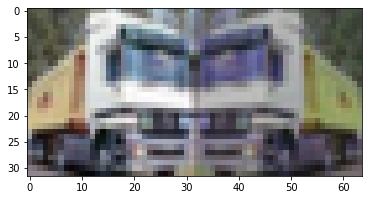

In [7]:
(x1,x2), y = pretrain_dataset[1]
print("Image x1 shape: ", x1.shape, 
      "\nImage x2 shape: ", x2.shape, 
      "\nclass index y: ", y, "\n")

merged_images = np.concatenate([x1,x2], axis=1)
plt.imshow(merged_images)

In [8]:
class EncoderWithProjectionHead(nn.Module):
    encoder : nn.Sequential

    def setup(self):
        self.proj_head = nn.Sequential([
            nn.Dense(features=128), 
            nn.relu, 
            nn.Dense(features=10)
            ])

    def __call__(self, x):
        x = self.encoder(x)
        return self.proj_head(x)

In [36]:
class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict

def create_train_state(model, params, config, freeze_encoder=False):
    if freeze_encoder:
        tx = optax.multi_transform({
                'zero': zero_grads(), 
                'sgd': optax.sgd(
                    config["learning_rate"], 
                    config["momentum"],
                )
            },
            freeze({'backbone':'zero', 'head': 'sgd'})
        )
    else:
        tx = optax.sgd(config["learning_rate"], config["momentum"])
    return TrainState.create(
        apply_fn=model.apply,
        params=params["params"],
        tx=tx,
        batch_stats=params['batch_stats']
    )

In [22]:
nu=3
jax.nn.one_hot(jnp.array([-1, 3]), num_classes = nu)

DeviceArray([[0., 0., 0.],
             [0., 0., 0.]], dtype=float32)

In [37]:
t_col = 1
t_row = 1


@jax.jit
def apply_model(train_state, X1, X2):
    def loss_fn(params):
        logits1, _ = train_state.apply_fn(
            {
                'params': params,
                'batch_stats': train_state.batch_stats,
            },
            X1,
            mutable=['batch_stats']
        )
        logits2, new_state = train_state.apply_fn(
            {
                'params': params,
                'batch_stats': train_state.batch_stats,
            },
            X2,
            mutable=['batch_stats']
        )

        N, C = logits2.shape
        
        p_x2_cond_y = jax.nn.softmax(logits2 / t_col, axis=1)
        p_x2_cond_y_sum = jnp.sum(p_x2_cond_y, axis=1, keepdims=True)
        # shapes=[(42, 128), (42,)]
        lhs = p_x2_cond_y / p_x2_cond_y_sum
        
        p_y_cond_x1 = jax.nn.softmax(logits1 / t_row, axis=0)
        p_y_cond_x1_sum = jnp.sum(p_y_cond_x1, axis=0, keepdims=True)
        rhs = (
            jnp.log(N / C)
            + jnp.log(p_y_cond_x1)
            - jnp.log(p_y_cond_x1_sum)
        )
        loss = -jnp.sum(lhs * rhs, axis=1)
        return jnp.mean(loss), (new_state['batch_stats'], logits1, logits2)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (batch_stats, logits1, logits2)), grads = grad_fn(train_state.params)

    train_state = train_state.apply_gradients(grads=grads, batch_stats=batch_stats)
    return (train_state, logits1, logits2), loss


@jax.jit
def apply_model_supervised(state, X, Y):
  """
  Computes gradients, loss and accuracy for a single batch via supervised 
  training, not self-supervised training.
  """
  tau = 0.5
  def loss_fn(params):
    logits, new_model_state = state.apply_fn({'params': params, 
                             'batch_stats': state.batch_stats}, X,
                              mutable=['batch_stats'])

    labels = jax.nn.one_hot(Y, num_classes=NUM_CLASS)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == Y)
    return loss, (new_model_state, accuracy)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (new_model_state, accuracy)), grads = grad_fn(state.params)
  
  new_state = state.apply_gradients(
      grads=grads, batch_stats=new_model_state['batch_stats'])

  return (new_state, accuracy), loss

def supervised_epoch(state, train_dl):
  """
  Train for a single epoch with supervised loss.
  """
  
  epoch_loss = []
  epoch_accuracy = []

  train_dl_tqdm = tqdm.tqdm(train_dl)

  for step, (X, Y) in enumerate(train_dl_tqdm):

    (new_state, accuracy), loss = apply_model_supervised(state, X, Y)
    state = new_state
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
    train_dl_tqdm.set_postfix({'train_loss': loss.item(), 'train_acc': accuracy})

  return state, jnp.array(epoch_loss).mean(), jnp.array(epoch_accuracy).mean()

def pretrain_epoch(train_state, train_dataloader):
    epoch_loss = []
    
    train_dataloader_tqdm = tqdm(train_dataloader)
    for step, ((X1,X2), Y) in enumerate(train_dataloader_tqdm):
        (train_state, Z1, Z2), loss = apply_model(train_state, X1, X2)
        epoch_loss.append(loss)
        train_dataloader_tqdm.set_postfix({'train_loss': loss.item()})
        
    return train_state, np.mean(epoch_loss)


In [38]:
# Source: https://colab.research.google.com/drive/1Y2IiAG69nKQSoIKAOAWC8uypdP7TGFqF?usp=sharing#scrollTo=TqDvTL_tIQCH
def zero_grads():
    def init_fn(_): 
        return ()
    def update_fn(updates, state, params=None):
        return jax.tree_map(jnp.zeros_like, updates), ()
    return optax.GradientTransformation(init_fn, update_fn)

In [39]:
@jax.jit
def eval_step(state, X, Y):

    logits = state.apply_fn({'params': state.params, 
                             'batch_stats': state.batch_stats}, X,
                              mutable=False)
    labels = jax.nn.one_hot(Y, num_classes=NUM_CLASS)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == Y)

    return loss, accuracy

def compute_validation_performance(state, val_data_loader):
  """
  Computes the given model's mean loss and accuracy on the validation set.
  """
  val_losses = []
  val_accs = []

  val_dl_tqdm = tqdm.tqdm(val_data_loader)

  for X, Y in val_dl_tqdm:
    
    loss, accuracy = eval_step(state, X, Y)
    val_losses.append(loss)
    val_accs.append(accuracy)

    val_dl_tqdm.set_postfix({'val_loss': loss.item(), 'val_acc': accuracy.item()})

  return jnp.array(val_losses).mean().item(), jnp.array(val_accs).mean().item()

In [40]:
key1 = random.PRNGKey(42)

In [41]:
# CLASSIFICATION HEAD
# ----- For retriving from Checkpoint------
# retrive the checkpoint -> output you get the trainstate of the trained model
key2, param_key = random.split(key1)

dummy_input = np.zeros((8,32,32,3))

# n_classes doesn't matter, we remove the only layer impacted by it anyway.
# But we need to pass it to construct a ResNet. 
base_model = jax_resnet.ResNet18(n_classes=2)

base_params = base_model.init(rngs=param_key, x=dummy_input)
encoder = EncoderWithProjectionHead(encoder=nn.Sequential(base_model.layers[:-1]))
pretrain_params = encoder.init(rngs=param_key, x=dummy_input)

config = {"learning_rate": 0.01, "momentum": 0.9}
pretrain_dataloader = NumpyLoader(pretrain_dataset, batch_size=256)
pretrain_state = create_train_state(encoder, pretrain_params, config)
train_state_encoder_state = flax.training.checkpoints.restore_checkpoint('/work/checkpoint_999', target=pretrain_state)
# ----- For retriving from Checkpoint------


# print(train_state_encoder_state)
# create a encoder model, and initialise them with the parameters from the trained model -> encoder model with the parameters from the trained state
trained_encoder = EncoderWithProjectionHead(encoder=nn.Sequential(base_model.layers[:-1]))
pretrain_params = trained_encoder.init(rngs=param_key, x=dummy_input)

pretrain_params = unfreeze(pretrain_params)
pretrain_params['params']['backbone'] = train_state_encoder_state.params
pretrain_params['batch_stats']['backbone'] = train_state_encoder_state.batch_stats
pretrain_params = freeze(pretrain_params)

class AddClassificationLayerToBackbone(nn.Module):
    backbone : nn.Sequential
    num_classes : int
        
    def setup(self):
        self.head = nn.Sequential([ 
            nn.Dense(features=self.num_classes, use_bias=False)
            ])
    
    def __call__(self, x):
        x = self.backbone(x)
        return self.head(x)

# use this model to trim the final layer, that is get the encoder and add a classfication head
classification_model = AddClassificationLayerToBackbone(backbone=trained_encoder.encoder, num_classes=20)

# classification_model
finetune_params = classification_model.init(param_key, dummy_input)
finetune_params = unfreeze(finetune_params)

finetune_params['params']['backbone'] = train_state_encoder_state.params['encoder']
finetune_params['batch_stats']['backbone'] = train_state_encoder_state.batch_stats['encoder']
finetune_params = freeze(finetune_params)

output = classification_model.apply(finetune_params, dummy_input, mutable=False)
output.shape, output.dtype



((8, 20), dtype('float32'))

In [44]:
supervised_train_dataloader = NumpyLoader(supervised_dataset_1p, batch_size=128)
val_dataloader = NumpyLoader(val_dataset, batch_size=128)

finetune_config = {"learning_rate": 0.01, "momentum": 0.9}
finetune_state = create_train_state(classification_model, finetune_params, finetune_config, freeze_encoder=True)
NUM_CLASS = 20

for epoch in range(5):
  finetune_state, train_loss, train_acc = supervised_epoch(state=finetune_state, train_dl=supervised_train_dataloader)
  print(f"Epoch {epoch}: train loss {train_loss:.2f}, train accuracy {train_acc:.2f}")

  val_loss, val_acc = compute_validation_performance(finetune_state, val_dataloader)
  print(f"Epoch {epoch}: val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}\n")

 75%|███████▌  | 3/4 [00:17<00:05,  5.90s/it, train_loss=3.14, train_acc=0.1015625]


KeyboardInterrupt: ignored

In [43]:
# use this model to trim the final layer, that is get the encoder and add a classfication head
num_classes = 20
classification_model = AddClassificationLayerToBackbone(backbone=trained_encoder.encoder)
# classification_model
finetune_params = classification_model.init(param_key, dummy_input)
finetune_params = unfreeze(finetune_params)

finetune_params['params']['backbone'] = train_state_encoder_state.params['encoder']
finetune_params['batch_stats']['backbone'] = train_state_encoder_state.batch_stats['encoder']
finetune_params = freeze(finetune_params)

finetune_config = {"learning_rate": 0.01, "momentum": 0.9}
finetune_state = create_train_state(classification_model, finetune_params, finetune_config, freeze_encoder=True)

for epoch in range(5):
  finetune_state, train_loss, train_acc = supervised_epoch(state=finetune_state, train_dl=supervised_train_dataloader)
  print(f"Epoch {epoch}: train loss {train_loss:.2f}, train accuracy {train_acc:.2f}")

  val_loss, val_acc = compute_validation_performance(finetune_state, val_dataloader)
  print(f"Epoch {epoch}: val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}\n")

TypeError: ignored

In [ ]:
# use this model to trim the final layer, that is get the encoder and add a classfication head
num_classes = 20
classification_model = AddClassificationLayerToBackbone(backbone=trained_encoder.encoder, num_classes=num_classes)
# classification_model
finetune_params = classification_model.init(param_key, dummy_input)
finetune_params = unfreeze(finetune_params)

finetune_params['params']['backbone'] = train_state_encoder_state.params['encoder']
finetune_params['batch_stats']['backbone'] = train_state_encoder_state.batch_stats['encoder']
finetune_params = freeze(finetune_params)

finetune_config = {"learning_rate": 0.01, "momentum": 0.9}
finetune_state = create_train_state(classification_model, finetune_params, finetune_config, freeze_encoder=True)

for epoch in range(5):
  finetune_state, train_loss, train_acc = supervised_epoch(state=finetune_state, train_dl=supervised_train_dataloader, num_classes = num_classes)
  print(f"Epoch {epoch}: train loss {train_loss:.2f}, train accuracy {train_acc:.2f}")

  val_loss, val_acc = compute_validation_performance(finetune_state, val_dataloader)
  print(f"Epoch {epoch}: val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}\n")